# Doppler Lidar Vertical Velocity Exploration
### Author: Daniel Hogan
### Date Created: October 23, 2024

This notebook will download and explore the vertical velocity products from the SAIL doppler lidar deployed throughout winters 2022 and 2023. It will provide some statistics of vertical velocity variance over the entire winter and over select long, and short-intense sublimation events. 

# 1. Data and Imports

In [1]:
# general
import datetime as dt
import json
# data 
import xarray as xr 
import numpy as np
import pandas as pd
from scipy import stats as stats 
import statsmodels.api as sm
from sublimpy import utils 
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
# helper tools
from scripts.get_sail_data import get_sail_data
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.4.4


In [2]:
# load in the big events from winter 2022
w22_long_events = pd.read_csv('../../01_data/processed_data/sublimation/w22_large_sublimation_long_events.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')
w22_spiky_events =pd.read_csv('../../01_data/processed_data/sublimation/w22_large_sublimation_spiky_events.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')

# load in the big events from winter 2023
w23_long_events = pd.read_csv('../../01_data/processed_data/sublimation/w23_large_sublimation_long_events.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')
w23_spiky_events =pd.read_csv('../../01_data/processed_data/sublimation/w23_large_sublimation_spiky_events.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')


In [3]:
w22_long_events_start = w22_long_events.reset_index().groupby('event').first()['index']
w22_long_events_end = w22_long_events.reset_index().groupby('event').last()['index']
w22_spiky_events_start = w22_spiky_events.reset_index().groupby('event').first()['index']
w22_spiky_events_end = w22_spiky_events.reset_index().groupby('event').last()['index']
# get the start and end datetimes of the events
w23_long_events_start = w23_long_events.reset_index().groupby('event').first()['time']
w23_long_events_end = w23_long_events.reset_index().groupby('event').last()['time']
w23_spiky_events_start = w23_spiky_events.reset_index().groupby('event').first()['time']
w23_spiky_events_end = w23_spiky_events.reset_index().groupby('event').last()['time']

In [4]:
# make 10 minute interval time series ofr each event
def get_event_times(event_start, event_end, freq='10T'):
    event_times = []
    for event in event_start.index.unique():
        start = event_start.loc[event]
        end = event_end.loc[event]
        time = pd.date_range(start, end, freq=freq)
        event_times.append(time)
    return pd.Series(np.concatenate(event_times))

# get the 10 minute time series for each event
w22_long_events_10min = get_event_times(w22_long_events_start, w22_long_events_end)
w22_spiky_events_10min = get_event_times(w22_spiky_events_start, w22_spiky_events_end)
w23_long_events_10min = get_event_times(w23_long_events_start, w23_long_events_end)
w23_spiky_events_10min = get_event_times(w23_spiky_events_start, w23_spiky_events_end)

In [5]:
# Function to load ARM credentials
def load_arm_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.act_config.json'
credentials = load_arm_credentials(credential_path)
# api token and username for ARM
api_username = credentials.get('username')
api_token = credentials.get('token')

In [6]:
# establish start and ends of the different winters
start_22, end_22 = dt.datetime(2021, 12, 1), dt.datetime(2022, 3, 31)
start_23, end_23 = dt.datetime(2022, 12, 1), dt.datetime(2023, 3, 31)

In [7]:
sail_datastream= "gucdlprofwstats4newsM1.c1"
storage_directory = '/home/dlhogan/GitHub/Synoptic-Sublimation/01_data/processed_data/sail/gucdlprofwstats'
# create empty data dictionary
data_loc_dict = {}

def download_wstats_data(sail_datastream, start, end, storage_directory):
        if (os.path.exists(f"{storage_directory}/{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")): 
                print(f"{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc already exists")
                print('-------------------')
                # add the filename to the dictionary which can be used if we want to load the data
                wstats_data = xr.open_dataset(os.path.join(storage_directory,f"{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc"))
        else:
                wstats_data = get_sail_data(api_username,
                                                api_token,
                                                sail_datastream,
                                                startdate=start.strftime('%Y%m%d'),
                                                enddate=end.strftime('%Y%m%d'))
                wstats_data.to_netcdf(f"{storage_directory}/{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")
        return wstats_data

w22_wstats_data = download_wstats_data(sail_datastream, start_22, end_22, storage_directory)
w23_wstats_data = download_wstats_data(sail_datastream, start_23, end_23, storage_directory)

gucdlprofwstats4newsM1_20211201_20220331.nc already exists
-------------------
gucdlprofwstats4newsM1_20221201_20230331.nc already exists
-------------------


# Filter Data

In [8]:
def filter_wstats_data(wstats_data, heights=None, variables=None, localize_time=False, add_time_grouper=True):
    # write a docstring for the function
    """
    This function filters the wstats data to only include the heights and variables specified.
    """
    # filter the data by height and variables
    if heights is None:
        pass
    else:
        wstats_data_filtered = wstats_data.sel(height=heights)  
    if variables is None:
        pass
    else:
        wstats_data_filtered = wstats_data_filtered[variables]
    if localize_time:
        wstats_data_filtered['time'] = pd.to_datetime(wstats_data_filtered.time).tz_localize('UTC').tz_convert('US/Mountain').tz_localize(None)
    else:
        pass
    if add_time_grouper:
        # I want to group by individual 10-minute periods to average over the dataset.
        # let's create a new array that indexes what 10-minute period each time belongs to
        # first, create an array of each 10-minute period
        index_array = np.arange(0,24*6,1)
        # then, create an array of the time values
        time_range = pd.date_range("2022-12-01", "2022-12-02", freq='10min').time
        # then, create a dictionary that maps the time values to the index array
        time_index= pd.Series(dict(zip(time_range, index_array)))
        # then, create a new array that maps the time values to the index array
        # inefficient, but it works, can I make it faster?
        # time_index_array = np.array([time_index_dict[time.dt.time.item()] for time in wstats_data_filtered.time])
        time_index_array = time_index.loc[wstats_data_filtered.time.dt.time].values
        wstats_data_filtered = wstats_data_filtered.assign(time_index=('time', time_index_array))
    else:
        pass
    return wstats_data_filtered

# filter the data to only include the heights and variables we want
w22_wstats_data_filtered = filter_wstats_data(w22_wstats_data, heights=slice(95,1000), variables=['snr','w','w_variance','noise'], localize_time=False, add_time_grouper=True)
w23_wstats_data_filtered = filter_wstats_data(w23_wstats_data, heights=slice(95,1000), variables=['snr','w','w_variance','noise'], localize_time=False, add_time_grouper=True)

# convert to dataframe, may not use
# wstats_df = utils.modify_df_timezone(wstats_data.to_dataframe().reset_index(), 'UTC', 'US/Mountain')
# wstats_df['time_low'] = wstats_df['time'] - dt.timedelta(minutes=5)
# wstats_df['time_high'] = wstats_df['time'] + dt.timedelta(minutes=5)
# wstats_df['height_low'] = wstats_df['height'] - 15
# wstats_df['height_high'] = wstats_df['height'] + 15


In [9]:
# 2022 
w22_daily_stats = w22_wstats_data_filtered.groupby('time_index').mean()
w22_daily_stats_long_events = w22_wstats_data_filtered.sel(time=w22_long_events_10min.values).groupby('time_index').mean()
w22_daily_stats_spiky_events = w22_wstats_data_filtered.sel(time=w22_spiky_events_10min.values).groupby('time_index').mean()
# Get avearage over 50 meter bins for the whole winter
w22_height_stats = w22_wstats_data_filtered.groupby_bins('height', bins=np.arange(100,1000,50)).mean()
# Get average over 50 meter bins for the long events
w22_height_stats_long_events = w22_wstats_data_filtered.sel(time=w22_long_events_10min.values).groupby_bins('height', bins=np.arange(100,1000,50)).mean()
# Get average over 50 meter bins for the spiky events
w22_height_stats_spiky_events = w22_wstats_data_filtered.sel(time=w22_spiky_events_10min.values).groupby_bins('height', bins=np.arange(100,1000,50)).mean()

# 2023
w23_daily_stats = w23_wstats_data_filtered.groupby('time_index').mean()
w23_daily_stats_long_events = w23_wstats_data_filtered.sel(time=w23_long_events_10min.values).groupby('time_index').mean()
w23_daily_stats_spiky_events = w23_wstats_data_filtered.sel(time=w23_spiky_events_10min.values).groupby('time_index').mean()
# Get avearage over 50 meter bins for the whole winter
w23_height_stats = w23_wstats_data_filtered.groupby_bins('height', bins=np.arange(100,1000,50)).mean()
# Get average over 50 meter bins for the long events
w23_height_stats_long_events = w23_wstats_data_filtered.sel(time=w23_long_events_10min.values).groupby_bins('height', bins=np.arange(100,1000,50)).mean()
# Get average over 50 meter bins for the spiky events
w23_height_stats_spiky_events = w23_wstats_data_filtered.sel(time=w23_spiky_events_10min.values).groupby_bins('height', bins=np.arange(100,1000,50)).mean()

# Figures

### Vertical Velocity Daily Timeseries

#### 2022

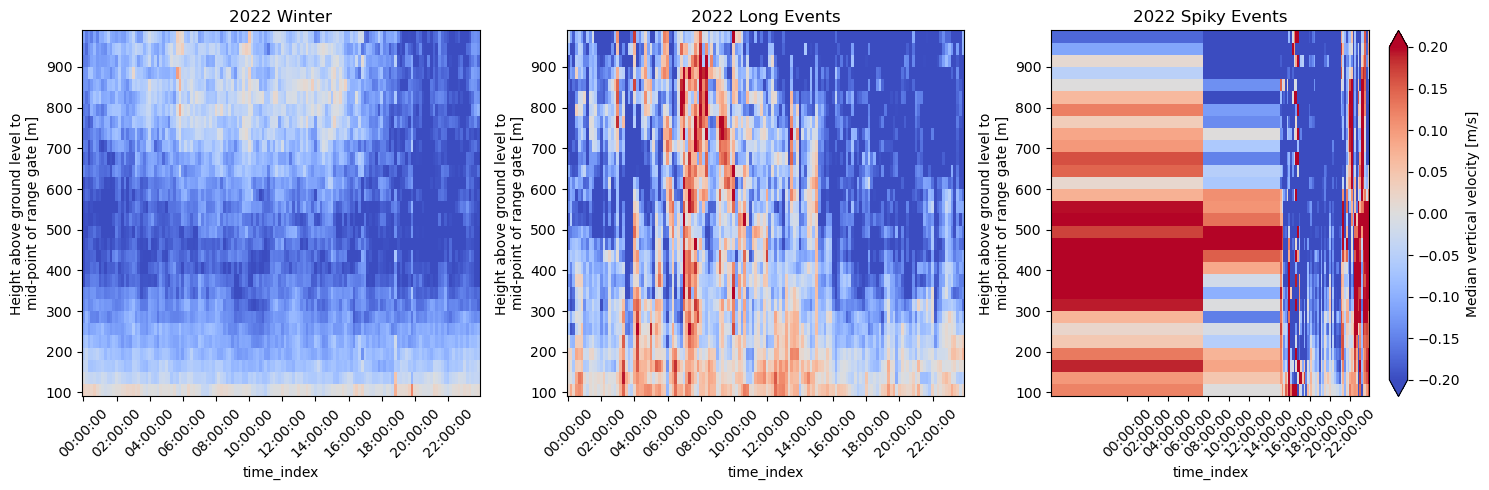

In [10]:
fig, axs = plt.subplots(ncols=3,figsize=(15,5), tight_layout=True)

# plot the average w for the whole winter
ax = axs[0]
w22_daily_stats['w'].plot(x='time_index',y='height',vmin=-0.2, vmax=0.2, ax=ax, cmap='coolwarm', add_colorbar=False)
ax.set_title('2022 Winter')

# plot the average w for the long events
ax = axs[1]
w22_daily_stats_long_events['w'].plot(x='time_index',y='height',vmin=-0.2, vmax=0.2, ax=ax, cmap='coolwarm', add_colorbar=False)
ax.set_title('2022 Long Events')

# plot the average w for the spiky events
ax = axs[2]
w22_daily_stats_spiky_events['w'].plot(x='time_index',y='height',vmin=-0.2, vmax=0.2, ax=ax, cmap='coolwarm', add_colorbar=True)
ax.set_title('2022 Spiky Events')

# adjust the x=axis to show time of day
time_range = pd.date_range("2022-12-01", "2022-12-01 22:50", freq='10min').time
for ax in axs:
    ax.set_xticks(np.arange(0,144,12))
    ax.set_xticklabels(time_range[::12], rotation=45);

#### 2023

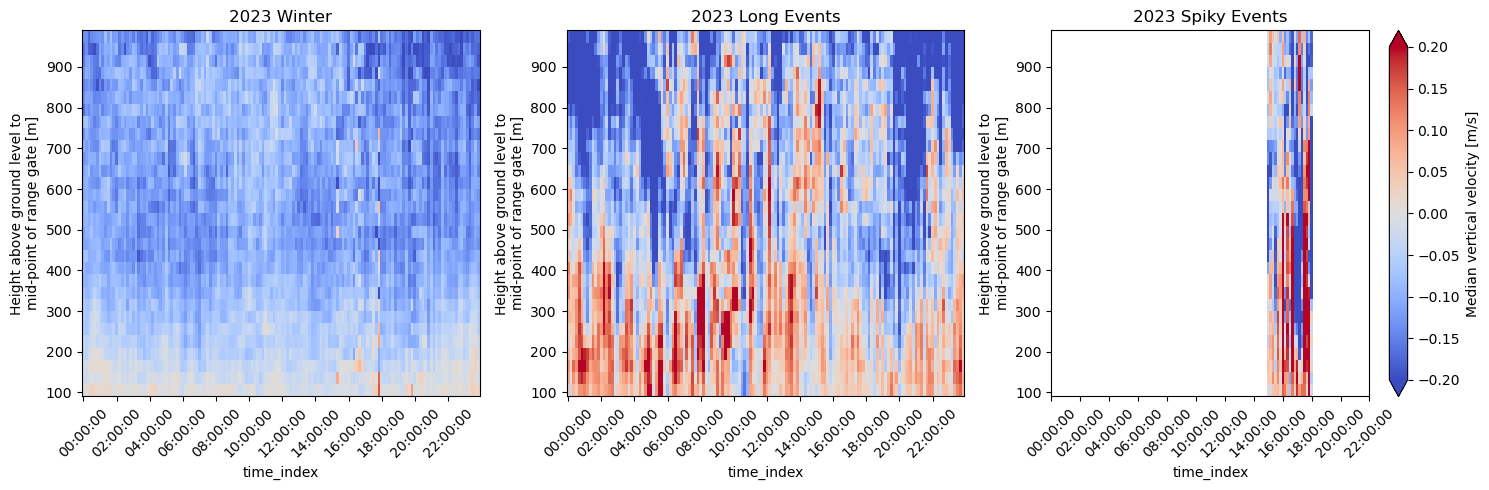

In [11]:
fig, axs = plt.subplots(ncols=3,figsize=(15,5), tight_layout=True)

# plot the average w for the whole winter
ax = axs[0]
w23_daily_stats['w'].plot(x='time_index',y='height',vmin=-0.2, vmax=0.2, ax=ax, cmap='coolwarm', add_colorbar=False)
ax.set_title('2023 Winter')

# plot the average w for the long events
ax = axs[1]
w23_daily_stats_long_events['w'].plot(x='time_index',y='height',vmin=-0.2, vmax=0.2, ax=ax, cmap='coolwarm', add_colorbar=False)
ax.set_title('2023 Long Events')

# plot the average w for the spiky events
ax = axs[2]
w23_daily_stats_spiky_events['w'].plot(x='time_index',y='height',vmin=-0.2, vmax=0.2, ax=ax, cmap='coolwarm', add_colorbar=True)
ax.set_title('2023 Spiky Events')

# adjust the x=axis to show time of day
time_range = pd.date_range("2022-12-01", "2022-12-01 23:50", freq='10min').time
for ax in axs:
    ax.set_xticks(np.arange(0,144,12))
    ax.set_xticklabels(time_range[::12], rotation=45);

### Vertical Velocity Velocity Box Plots
#### 2022

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


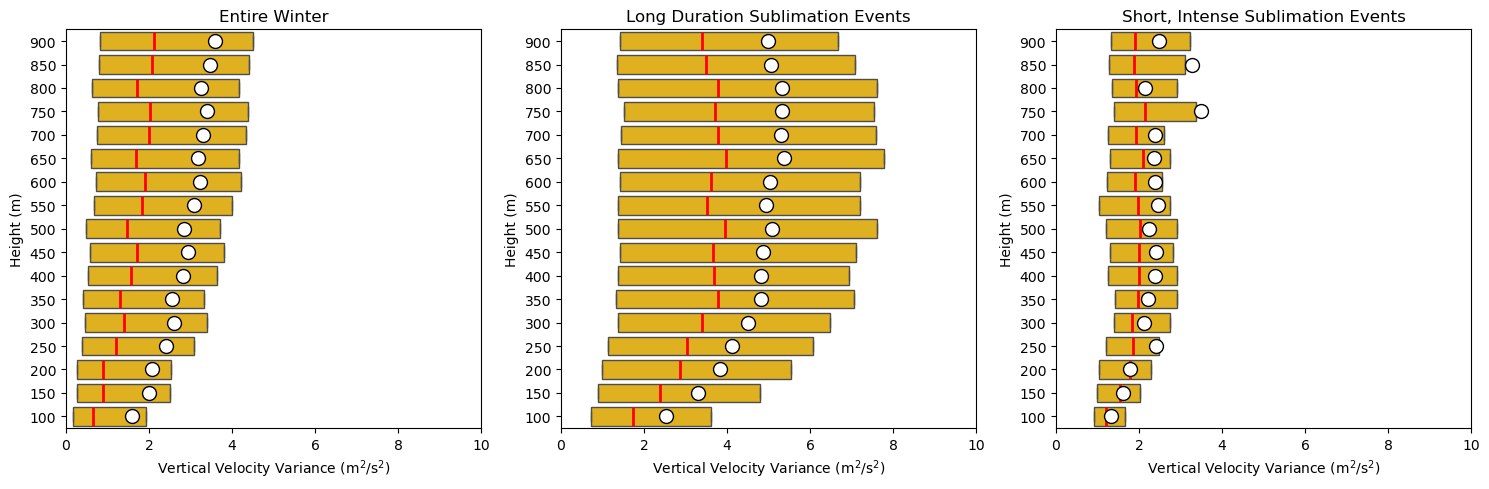

In [12]:
# for each height bin, make a horizontal box plot of the w variance
fig, axs = plt.subplots(ncols=3, tight_layout=True, figsize=(15,5))
# Entire Winter
ax = axs[0]
sns.boxplot(x='w_variance', y='height_bins', data=w22_height_stats.to_dataframe().reset_index(), ax=ax,
            # remove the max value dots
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"},
            medianprops={"color":"red",   
                         "linewidth":2},                    
            whis=[25,75],
            color='#FFC000'
            )
ax.set_title('Entire Winter')
# Long events
ax = axs[1]
sns.boxplot(x='w_variance', y='height_bins', data=w22_height_stats_long_events.to_dataframe().reset_index(), ax=ax,
            # remove the max value dots
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"},
            medianprops={"color":"red",
                         "linewidth":2},
            whis=[25,75],
            color='#FFC000'
            )
# set the titles and labels
ax.set_title('Long Duration Sublimation Events')
# Short events
ax = axs[2]
sns.boxplot(x='w_variance', y='height_bins', data=w22_height_stats_spiky_events.to_dataframe().reset_index(), ax=ax,
            # remove the max value dots
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"},
            medianprops={"color":"red",                       
                         "linewidth":2},                       
            whis=[25,75],
            color='#FFC000'
            )
# set the titles and labels
ax.set_title('Short, Intense Sublimation Events')

for ax in axs:
    ax.set_xlabel('Vertical Velocity Variance (m$^2$/s$^2$)')
    ax.set_ylabel('Height (m)')
    ax.set_xlim(0,10)
    ax.invert_yaxis()
    ax.set_yticklabels(np.arange(100,1000,50))

#### 2023

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


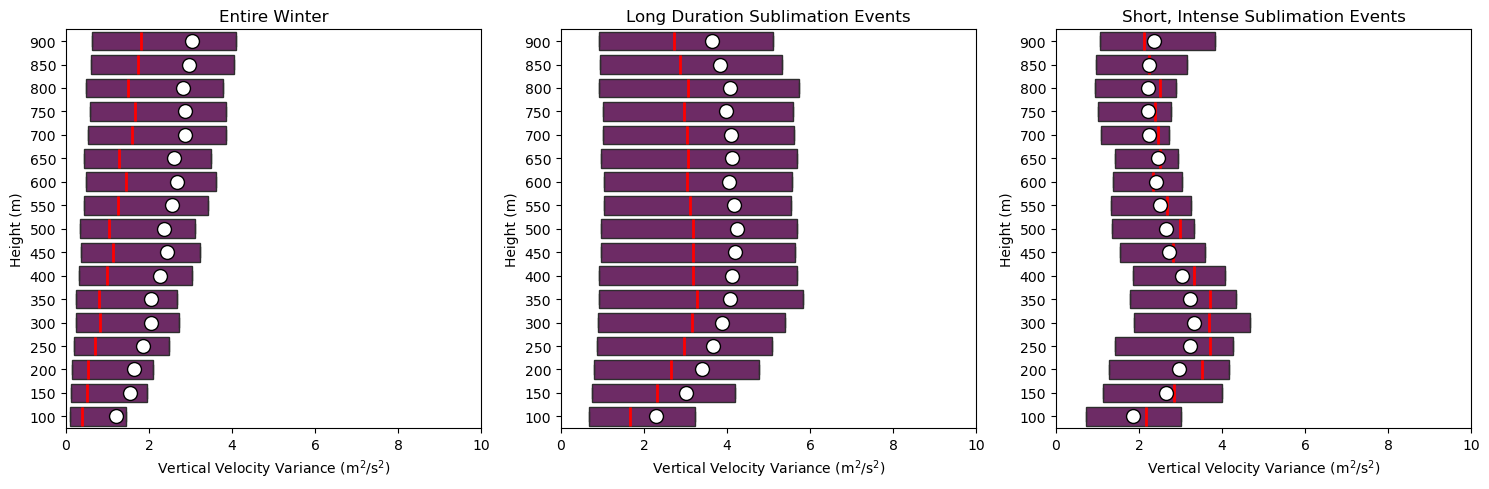

In [13]:
# for each height bin, make a horizontal box plot of the w variance
fig, axs = plt.subplots(ncols=3, tight_layout=True, figsize=(15,5))
# Entire Winter
ax = axs[0]
sns.boxplot(x='w_variance', y='height_bins', data=w23_height_stats.to_dataframe().reset_index(), ax=ax,
            # remove the max value dots
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"},
             medianprops={"color":"red",
                         "linewidth":2},           
            whis=[25,75],
            color='#78206E'
            )
ax.set_title('Entire Winter')
# Long events
ax = axs[1]
sns.boxplot(x='w_variance', y='height_bins', data=w23_height_stats_long_events.to_dataframe().reset_index(), ax=ax,
            # remove the max value dots
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"},
            medianprops={"color":"red",
                         "linewidth":2},            
            whis=[25,75],
            color='#78206E'
            )
# set the titles and labels
ax.set_title('Long Duration Sublimation Events')
# Short events
ax = axs[2]
sns.boxplot(x='w_variance', y='height_bins', data=w23_height_stats_spiky_events.to_dataframe().reset_index(), ax=ax,
            # remove the max value dots
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"},
            medianprops={"color":"red",
                         "linewidth":2},
            whis=[25,75],
            color='#78206E'
            )
# set the titles and labels
ax.set_title('Short, Intense Sublimation Events')

for ax in axs:
    ax.set_xlabel('Vertical Velocity Variance (m$^2$/s$^2$)')
    ax.set_ylabel('Height (m)')
    ax.set_xlim(0,10)
    ax.invert_yaxis()
    ax.set_yticklabels(np.arange(100,1000,50))

### Interesting Periods to explore

December 10, 2021: 
- Front looks like it passes around 12 UTC
- Cold frontal signature
- Wind shift
- Sublimation responses weakly, it was not dry beforehand
- Air prior to arrival is warm but moist. Winds were generally calm



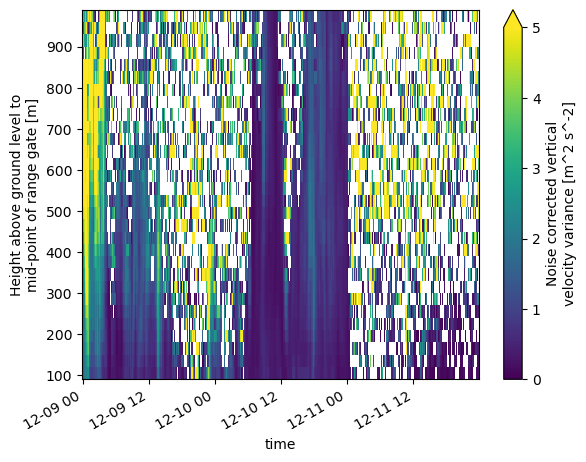

In [70]:
w22_wstats_data_filtered.sel(time=slice("2021-12-9", "2021-12-11"))['w_variance'].plot(x='time', vmin=0, vmax=5,)

February 11, 2023: Interesting to note this day had very little wind, mostly sunny conditions, warmth and dry air, but had very little sublimation. 
Check what synoptics were doing on this day in comparison


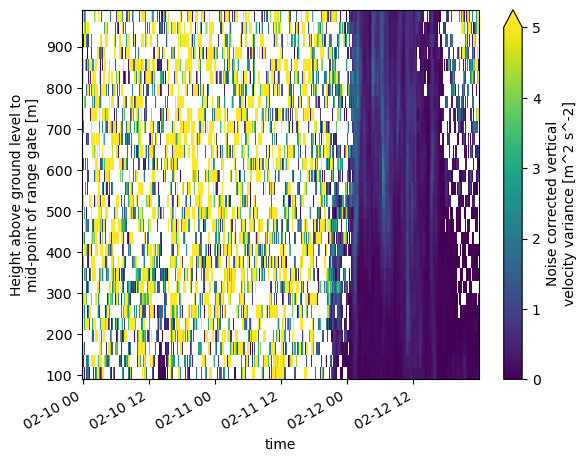

In [71]:
w23_wstats_data_filtered.sel(time=slice("2023-02-10", "2023-02-12"))['w_variance'].plot(x='time', vmin=0, vmax=5,)